# FINAL REPORT
# Coronary Artery Disease Gender-Based K-nn Classifier

# Introduction:

Coronary Artery Disease (CAD) is a condition characterized by the narrowing of or blockage of a coronary artery, responsible for supplying oxygenated blood to the heart. Narrowing of the artery’s passage is usually the result of plaque buildup overtime. CAD is often described as a chronic disease with a sudden acute syndrome - a blood clot forms in the artery and results in a heart attack, due to blood being unable to flow to the heart. As a heart attack-inducing condition, it is currently the leading cause of death in the world. As such, it is critical to identify risk factors and their relationships with this condition. Many factors have been identified over the years, some of which are present in the data set that will be used in this project. The data frame was obtained from a paper that used those variables to calculate the probability for the diagnosis of CAD (Detrano et al., 1989).


#### In this project, we want to answer the question: Given different numerical variables, can we predict a CAD diagnosis accurately in females and males?

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dbplyr)
library(ggplot2)
install.packages("themis")
library(themis)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

## Loading the data into the data set, and doing elaborate cleaning and wrangling on our raw data set.
### Table 1. Includes the cleaned and wrangled dataset to work with

In [2]:
#setting a fixed seed value (to be maintainied consistently throughout the entire project)
set.seed(50)


# Loading the dataset and ensuring that it is cleaned and wrangled
url <- "https://raw.githubusercontent.com/szulkifl/dsci-data-analysis-project-44/main/processed.hungarian.data.txt"
hungarian_data <- read_csv(url, col_names= c("age", "sex", "cp", "trestbps", 
                                             "chol", "fbs", "restecg", "thalac", "exang", "oldpeak", 
                                             "slope", "ca", "thal", "num" ),
                          show_col_types = FALSE) |>
                                             mutate(across(where(is.character), ~na_if(.x, "?"))) |> 
                                             mutate(trestbps = as.numeric(trestbps), 
                                                    chol = as.numeric(chol), 
                                                    restecg = as.numeric(restecg),
                                                    thalac = as.numeric(thalac),
                                                    num = as.character(num),
                                                    sex = as.character(sex)) |>
                                             mutate(num = fct_recode(num, "Negative" = "0", "Positive" = "1")) |>
                                             mutate(sex = recode(sex, "1" = "Male", "0" = "Female")) |>
                                             mutate(exang = recode(exang, "0" = "No", "1" = "Yes")) |>
                                             mutate (cp = recode( cp, "1" = "typical angina" , "2" = "atypical angina", 
                                                                "3" = "non-anginal pain", "4" = "asymptomatic" )) |>
                                             mutate (fbs = recode( fbs, "1" = "high fbs", "0" = "normal fbs")) |>
                  
                                             mutate(restecg = recode (restecg, "0" = "normal" , "1" = "abnormality", "2" = "hypertrophy"))

#cleaned and wrangled dataset
#Table. 1
hungarian_data

age,sex,cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal,num
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<fct>
28,Male,atypical angina,130,132,normal fbs,hypertrophy,185,No,0,NA,NA,NA,Negative
29,Male,atypical angina,120,243,normal fbs,normal,160,No,0,NA,NA,NA,Negative
29,Male,atypical angina,140,NA,normal fbs,normal,170,No,0,NA,NA,NA,Negative
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,Male,asymptomatic,155,342,high fbs,normal,150,Yes,3,2,NA,NA,Positive
58,Female,atypical angina,180,393,normal fbs,normal,110,Yes,1,2,NA,7,Positive
65,Male,asymptomatic,130,275,normal fbs,abnormality,115,Yes,1,2,NA,NA,Positive


First, we have loaded and tidied the data. We have renamed all the columns, replaced any missing values (0, ?) with NA, changed the variables to be the appropriate type given the kind of variable it is (ie. categorical, numerical), and changed the values within those variables to match the type (eg. column sex becomes categorical, and the original values 0 and 1 become "Female" and "Male", respectively.

## Proportion of Males and Females in entire data set
### Table 2. Proportions of male and female in original data set

In [3]:
#number of observations
n_obs <- nrow(hungarian_data)

hungarian_data_gender_proportion <- hungarian_data |>
                                    group_by(sex) |>
                                    summarize(total_number = n(),
                                              percentage = n()/n_obs * 100)

#total number of observations in data set
n_obs
#proportion table , Table. 2
hungarian_data_gender_proportion

[1] 294

sex,total_number,percentage
<chr>,<int>,<dbl>
Female,81,27.55102
Male,213,72.44898


As we can see, there is a large imbalance in this data set with regards to gender distribution. An overwhelming majority of 72% of the data set is occupied by observations for males, while a relatively small 28% of the data set is occupied with female data. This imbalance will be reflected in the training and testing data and should therefore be dealt with and evaluated accordingly.

## Returning percentage of missing values
### Table 3. Proportions of NA readings in dataset

cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.3401361,7.823129,2.721088,0.3401361,0.3401361,0.3401361,0,64.62585,98.97959,90.47619


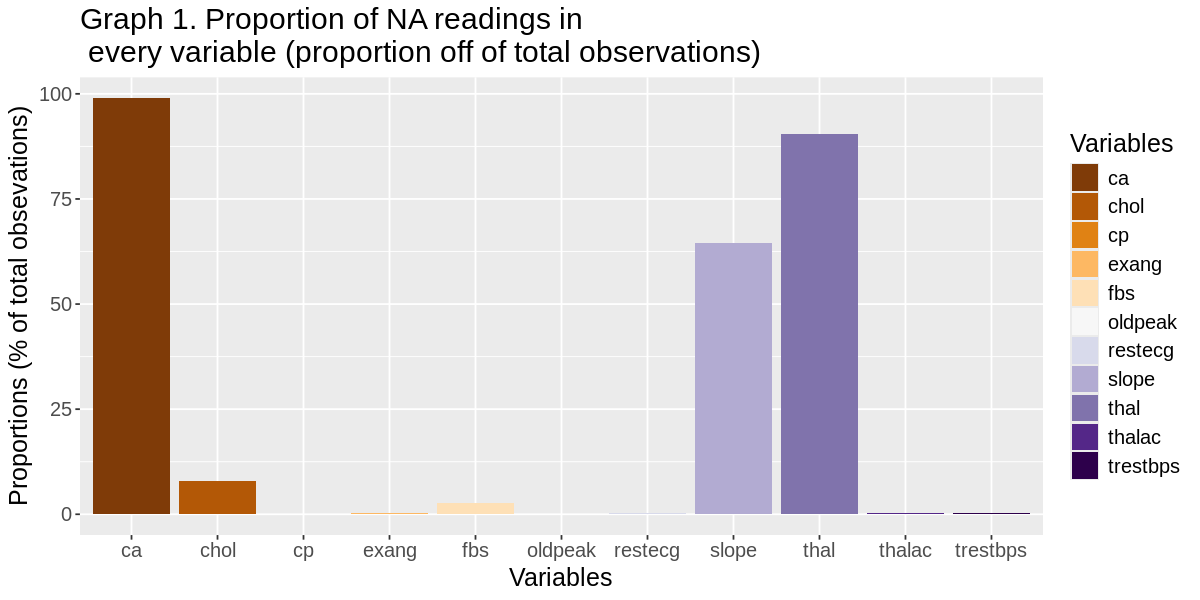

In [4]:
options(repr.plot.width = 10, repr.plot.height=5)

data_na_df <- hungarian_data |>
              select(cp:thal) |>
              map_df(~sum(is.na(.))) |>
              mutate(across(everything(), ~.x * (100/n_obs)))

data_na_df_vis <- pivot_longer(data_na_df,
                              cp:thal,
                              names_to = "Variables",
                              values_to = "Proportions") |>
                              ggplot(aes(x = Variables, y = Proportions, fill = Variables)) +
                              geom_bar(stat = "identity") +
                              scale_fill_brewer(palette = "PuOr") +
                              ggtitle("Graph 1. Proportion of NA readings in \n every variable (proportion off of total observations)") +
                              labs(x = "Variables",
                                  y = "Proportions (% of total obsevations)",
                                  fill = "Variables") +
                              theme(text = element_text(size = 15))
# Table 3.
data_na_df
# Graph 1.
data_na_df_vis

The table above returns the percentage of missing values in each variable, and the visualization above plots this information, with the variables on the x-axis against the percentage of missing values on the y-axis. We can see that the columns for ca, slope and thal are quite tall, and thus a large percentage of their observations are missing.

We ensure effective data analysis by removing select variables on the basis of two grounds: categorical variables and variable with a large proportion of NA readings (more explanation in Methodology section below).

**The variables we will discard are: cp, fbs, restecg, exang, ca, slope, thal** 

**The variables we will keep are: age (age), sex (sex), resting blood pressure(on admission to hospital) (trestbps), serum cholesterol in mg/di (chol), maximum heart rate achieved (thalac), ST depression induced by exercise relative to rest (oldpeak), and diagnosis(num)**

## Splitting the data into testing and training set
### Table 4. Hungarian Data Set which is cleaned off of the disposed variables
### Table 5. Training Data Set
### Table 6. Testing Data Set

In [5]:
hungarian_data_new <- hungarian_data |>
                  select(age,sex,trestbps,chol,thalac,oldpeak,num)

# hungarian_data_new is the modified and cleaned dataset, 
# it is the cleanest version of our dataset which will now 
# be split into training and testing for the purpose of analysis.

hungarian_data_split <- hungarian_data_new |>
                        initial_split(prop = 0.75, strata = num)
hungarian_data_train <- training(hungarian_data_split)
hungarian_data_test <- testing(hungarian_data_split)

# Table 4.
hungarian_data_new
# Table 5.
hungarian_data_train
#Table 6.
hungarian_data_test

age,sex,trestbps,chol,thalac,oldpeak,num
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,Male,130,132,185,0,Negative
29,Male,120,243,160,0,Negative
29,Male,140,NA,170,0,Negative
⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,Male,155,342,150,3,Positive
58,Female,180,393,110,1,Positive
65,Male,130,275,115,1,Positive


age,sex,trestbps,chol,thalac,oldpeak,num
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,Male,130,132,185,0,Negative
29,Male,120,243,160,0,Negative
29,Male,140,NA,170,0,Negative
⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,Male,155,342,150,3,Positive
58,Female,180,393,110,1,Positive
65,Male,130,275,115,1,Positive


age,sex,trestbps,chol,thalac,oldpeak,num
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
35,Female,140,167,150,0,Negative
36,Male,150,160,172,0,Negative
37,Female,130,211,142,0,Negative
⋮,⋮,⋮,⋮,⋮,⋮,⋮
66,Male,140,NA,94,1.0,Positive
44,Male,135,491,135,0.0,Positive
50,Male,140,341,125,2.5,Positive


## Elementary level exploratory analysis on current variables

#### Table 1e. Average value across all predictor variables based on sex and diagnosis

In [6]:
hungarian_train_mean <- hungarian_data_train |>
                        group_by(sex, num) |>
                        summarize(age_mean = mean(age, na.rm = TRUE),
                                  trestbps_mean = mean(trestbps, na.rm = TRUE),
                                  chol_mean = mean(chol, na.rm = TRUE),
                                  thalac_mean = mean(thalac, na.rm = TRUE),
                                  oldpeak_mean = mean(oldpeak, na.rm = TRUE))
# Table 1e
hungarian_train_mean

`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.


sex,num,age_mean,trestbps_mean,chol_mean,thalac_mean,oldpeak_mean
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,Negative,47.11321,127.2308,239.5625,146.9615,0.3075472
Female,Positive,48.71429,135.7143,308.0000,122.5714,1.0714286
Male,Negative,45.84091,130.3750,239.6125,146.9205,0.1704545
Male,Positive,49.36111,134.4167,264.2059,127.7778,1.3750000


#### Table 2e. Maximum value across all predictor variables based on sex and diagnosis

In [7]:
hungarian_train_max <- hungarian_data_train |>
                        group_by(sex, num) |>
                        summarize(age_max = max(age, na.rm = TRUE),
                                  trestbps_max = max(trestbps, na.rm = TRUE),
                                  chol_max = max(chol, na.rm = TRUE),
                                  thalac_max = max(thalac, na.rm = TRUE),
                                  oldpeak_max = max(oldpeak, na.rm = TRUE))
# Table 2e.
hungarian_train_max

`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.


sex,num,age_max,trestbps_max,chol_max,thalac_max,oldpeak_max
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,Negative,62,180,394,190,2
Female,Positive,59,180,393,150,2
Male,Negative,62,190,365,185,3
Male,Positive,65,180,603,175,5


#### Table 3e. Minimum value accross all predictor variables based on sex and diagnosis

In [8]:
hungarian_train_min <- hungarian_data_train |>
                        group_by(sex, num) |>
                        summarize(age_min = min(age, na.rm = TRUE),
                                  trestbps_min = min(trestbps, na.rm = TRUE),
                                  chol_min = min(chol, na.rm = TRUE),
                                  thalac_min = min(thalac, na.rm = TRUE),
                                  oldpeak_min = min(oldpeak, na.rm = TRUE))
# Table 3e.
hungarian_train_min

`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.


sex,num,age_min,trestbps_min,chol_min,thalac_min,oldpeak_min
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,Negative,30,100,160,90,0
Female,Positive,33,100,205,98,0
Male,Negative,28,98,85,98,0
Male,Positive,31,92,117,82,0


Tables 1e, 2e, and 3e observe the average, maximum and minimum values in our dataset for each assigned gender and diagnosis combination. The purpose of these tables is to gain a better understanding of the range of data in the form of a table, as opposed to the visualizations below. With these numbers, we can understand exactly the range and behaviour of the variables are considering.

#### Table 4e. Finding the number of Female and Male entries in the dataset

In [9]:
#number of observations
n_obs_train <- nrow(hungarian_data_train)

hungarian_data_gender_proportion_train <- hungarian_data_train |>
                                    group_by(sex) |>
                                    summarize(total_number = n(),
                                              percentage = n()/n_obs_train * 100)

#number of total observations in training data set
n_obs_train
# Table 4e.
hungarian_data_gender_proportion_train

[1] 220

sex,total_number,percentage
<chr>,<int>,<dbl>
Female,60,27.27273
Male,160,72.72727


We found the number of males and females in the training data so that when we observe any sex-based variables (ie. distribution of diagnoses with resepct to sex), we ensure awareness of the fact that the data would yield more positive male diagnoses, not necessarily because males are diagnosed positively more often than females, but because in this dataset, there are simply more males than females.

This information serves as definitive proof of the difference in the proportion of male and female observations in the training data, reflective of the difference in gender proportions of the original dataset. The reason for this statistic is to be a guide when evaluating our classifier, as it affects the differences in the training and even testing abilities of the classifier.

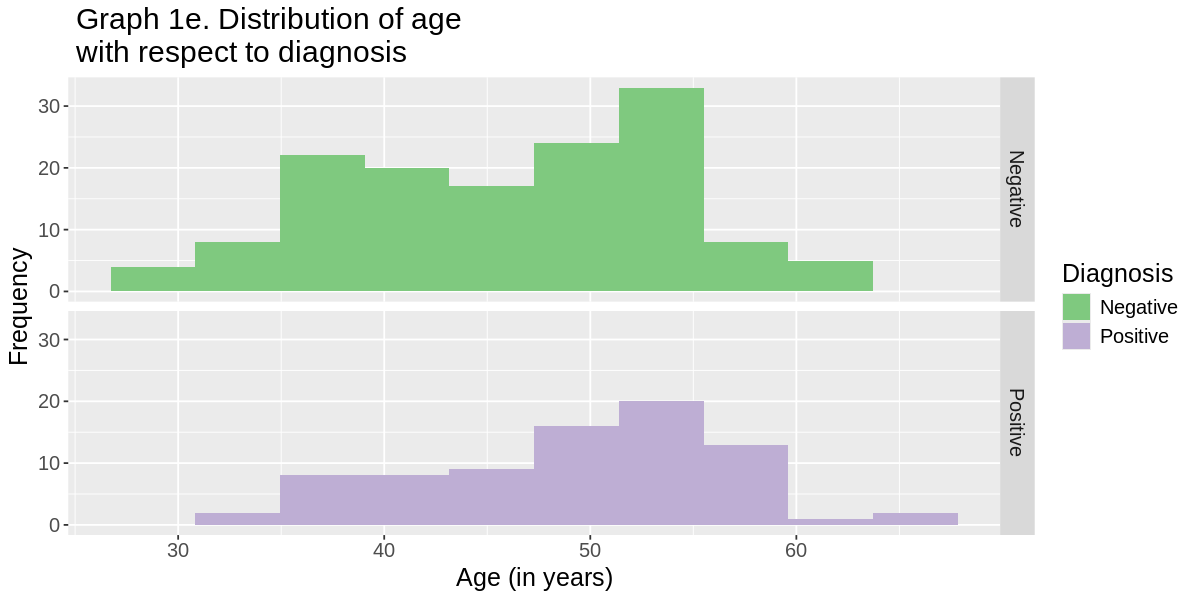

In [10]:
visualization_age <- hungarian_data_train |>
                     ggplot(aes(x = age, fill = num)) +
                     geom_histogram(bins = 10) +
                     labs(x = "Age (in years)", y = "Frequency", fill = "Diagnosis") +
                     facet_grid(rows = vars(num)) +
                     theme(text = element_text(size = 15)) +
                     ggtitle(" Graph 1e. Distribution of age \n with respect to diagnosis") + 
                     scale_fill_brewer(palette = "Accent")
#Graph 1e
visualization_age

This visualization allows us to see how age plays a role in diagnosing CAD. There is a lot of overlap in ages of those both positively and negatively diagnosed, but those who were positively diagnosed are within the age range of ~30-70 years old, while those who were negatively diagnosed are within the range of ~25-65. From this, we can infer that CAD tends to be found in a slightly older age range of individuals, and thus conclude that age may be a useful variable to consider.

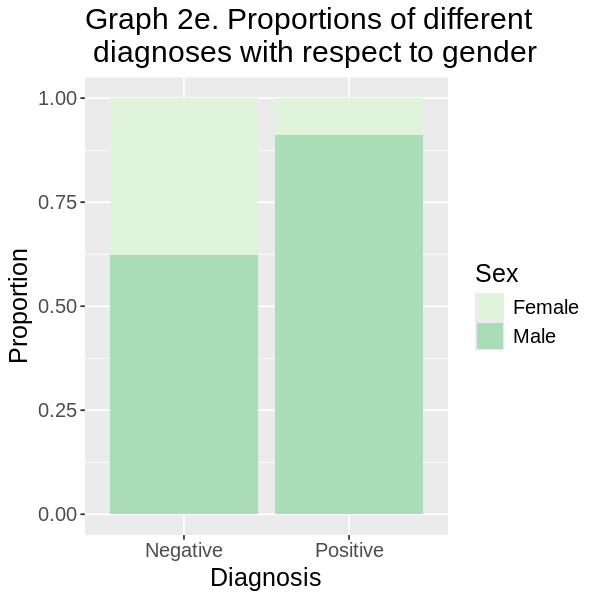

In [11]:
options(repr.plot.width = 5)
visualize_1 <- hungarian_data_train |>
               ggplot(aes(x = num, fill = sex)) +
               geom_bar(position = "fill") +
               labs(x = "Diagnosis", y = "Proportion", fill = "Sex") +
               scale_fill_brewer(palette = "GnBu") + 
               ggtitle("Graph 2e. Proportions of different \n diagnoses with respect to gender") + 
               theme(text = element_text(size = 15))
#Graph 2e.
visualize_1

This visualization allows us to see what proportion of males versus females are diagnosed with CAD. We know that there are more males than females in this dataset, so the fact that males are diagnosed more often than females for both diagnoses is not surprising. However, males are diagnosed positively more often than negatively, and vice versa for females, so we can infer that males are more at risk of CAD than females, and that sex may be a useful variable to consider.

Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”


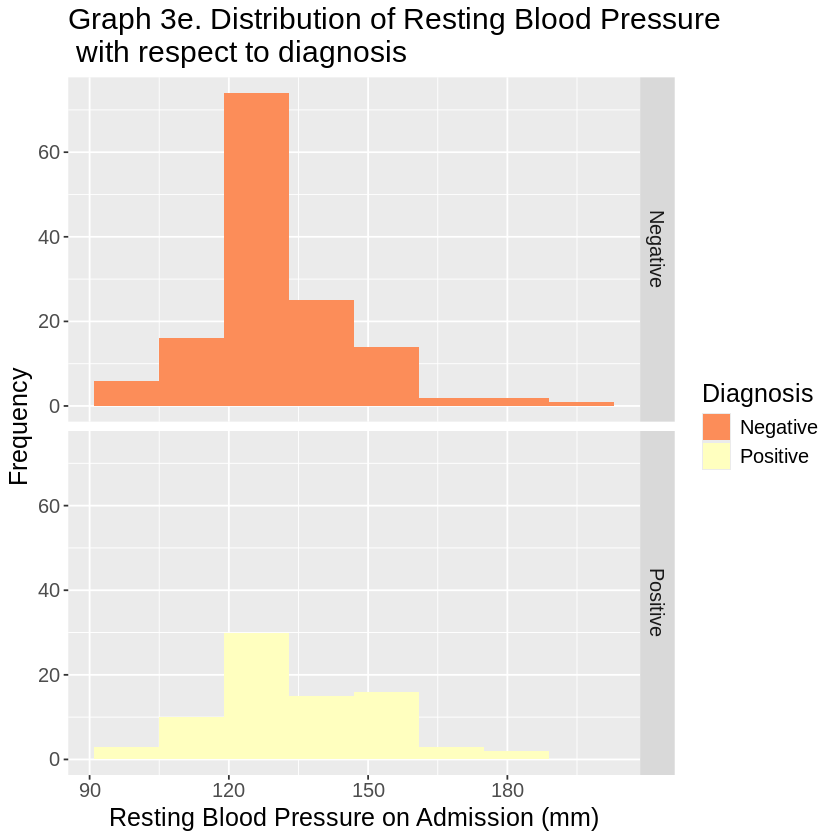

In [12]:
options(repr.plot.width = 7, repr.plot.height = 7)
hist_visualiz_trestbps <- hungarian_data_train |>
                 arrange(desc(age))  |>
                 ggplot(aes(x = trestbps, fill = num)) +
                 geom_histogram(bins = 8) +
                 facet_grid(rows = vars(num)) +
                 labs(x = "Resting Blood Pressure on Admission (mm)", y = "Frequency", fill = "Diagnosis") +
                 ggtitle("Graph 3e. Distribution of Resting Blood Pressure \n with respect to diagnosis") + 
                 scale_fill_brewer(palette = "RdYlGn") + 
                 theme(text = element_text(size = 15))

#Graph 3e.
hist_visualiz_trestbps

This visualization allows us to see the distribution of resting blood pressure values between positive and negative diagnoses. The range of values is greater for negative diagnoses than positive diagnoses, so higher blood pressure might rule out a CAD diagnosis, and because of this potential, it may be a useful variable to consider.

Warning message:
“Removed 17 rows containing non-finite outside the scale range (`stat_bin()`).”


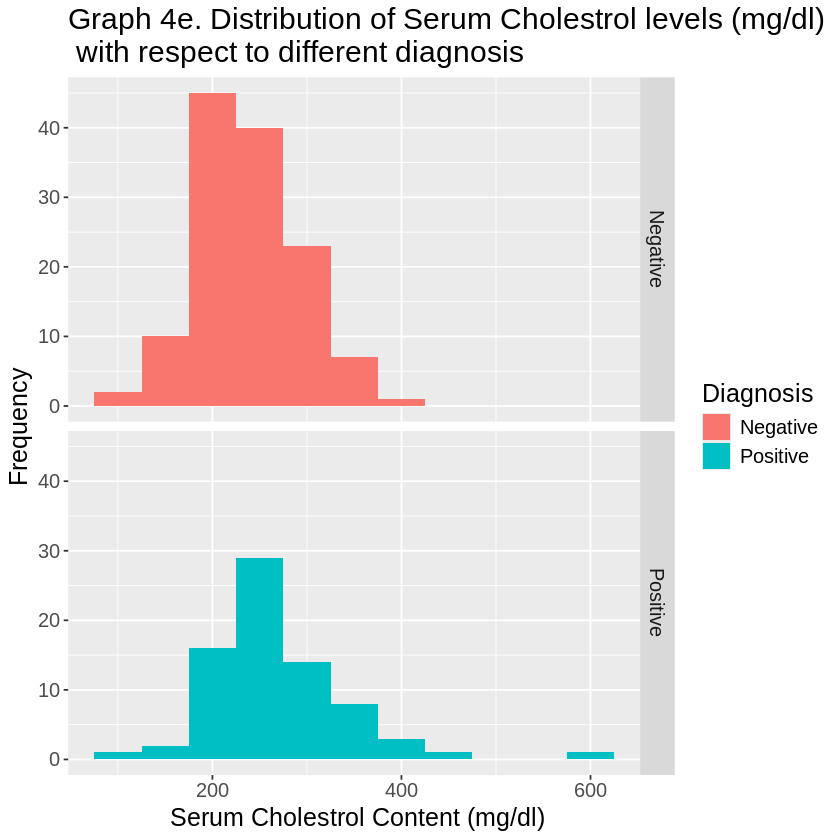

In [13]:
options(repr.plot.width = 7, repr.plot.height = 7)
hist_visualiz_chol <- hungarian_data_train |>
                 arrange(desc(age))  |>
                 ggplot(aes(x = chol, fill = num)) +
                 geom_histogram(binwidth = 50) +
                 facet_grid(rows = vars(num)) +
                 labs(x = " Serum Cholestrol Content (mg/dl)", y = "Frequency", fill = "Diagnosis") + 
                 ggtitle("Graph 4e. Distribution of Serum Cholestrol levels (mg/dl)\n with respect to different diagnosis") + 
                 theme(text = element_text(size = 15))

#Graph 4e.
hist_visualiz_chol

This visualization allows us to see the distribution of serum cholesterol content between positive and negative diagnoses. Serum content tends to be lower in negative diagnoses than positive diagnoses, and the range is also smaller than in positve diagnoses, so we can infer that cholesterol may be a useful variable to consider.

Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”


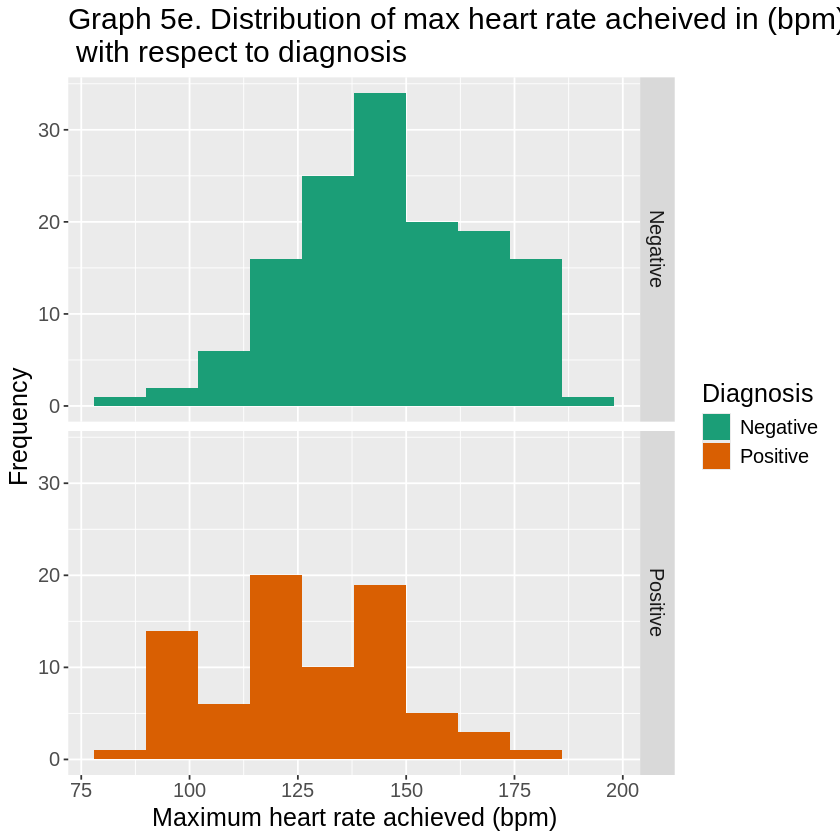

In [14]:
hist_visualize_thalac <- hungarian_data_train |>
                         ggplot(aes(x = thalac, fill = num)) +
                         geom_histogram(bins = 10) +
                         scale_fill_brewer(palette = "Dark2") +
                         labs(x = "Maximum heart rate achieved (bpm)", fill = "Diagnosis", y = "Frequency") +
                         ggtitle("Graph 5e. Distribution of max heart rate acheived in (bpm)\n with respect to diagnosis") +
                         facet_grid(rows = vars(num)) +
                         theme(text = element_text(size = 15))

#Graph 5e.
hist_visualize_thalac

This visualization allows us to see the distribution of maximum heart rate values achieved, between positive and negative diagnoses. The range of values in negative diagnoses are concentrated higher than in positive diagnoses, so a low BPM may be a factor in diagnosing CAD, and thus we can conclude this may be a useful variable to consider. 

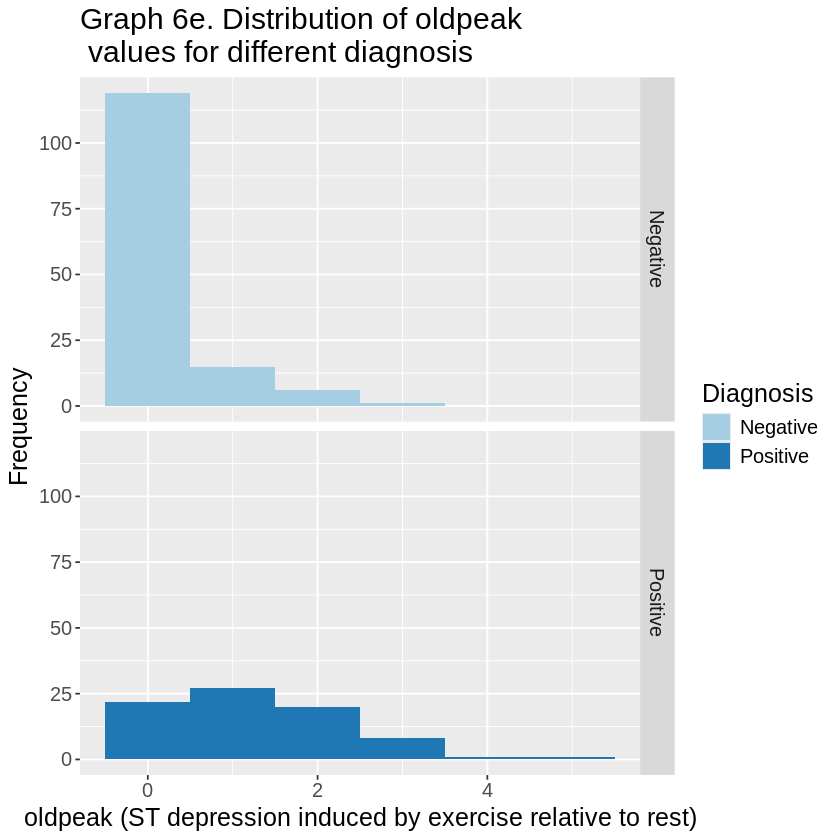

In [15]:
options(repr.plot.width = 7)
oldpeak_vis <- hungarian_data_train |>
               ggplot(aes(x = oldpeak, fill = num)) +
               geom_histogram(bins = 6) +
               facet_grid(rows = vars(num)) +
               labs(x = "oldpeak (ST depression induced by exercise relative to rest)",
                   y = "Frequency",
                   fill = "Diagnosis") +
               scale_fill_brewer(palette = "Paired") +
               ggtitle("Graph 6e. Distribution of oldpeak \n values for different diagnosis") +
               theme(text = element_text(size = 15))

#Graph 6e.
oldpeak_vis

The variable oldpeak measures how many times the ECG value measured in a patient drops below the J-joint threshold when exercising, relative to when resting. From this visualization, we can see the distribution of ST depression amounts between negative and positive diagnoses. The positive diagnosis has a larger range, meaning patients diagnosed with CAD tend to experience more ST depression than patients negatively diagnosed. We can infer from this greater range of values in positive diagnoses that this variable would be useful to consider.

# Methods:
The method employed in this data analysis makes use of the K Nearest Neighbors algorithm to produce two separate classifiers that allow us to run diagnosis on females and males separately. Producing two different classifiers to operate on females and males is necessary and efficient given the presence of biological differences between the two genders assigned at birth. This becomes an important factor when diagnosing a patient for the presence of most cardiovascular diseases.

The dataset is first wrangled and tidied into an efficient form to work with. This includes column name assignment, assignment of “Positive” and “Negative” diagnoses labels, and setting appropriate data types for all columns, including assigning the “num” column as our factor column. The data is further cleaned by removing variables on the basis of two grounds:

1. **Variables with a large proportion of NA readings are discarded on the grounds that the lack of readings for these particular variables will impede the judgment and calculations of the classifier, and will not contribute to the K-Classifier’s analysis.**
2. **Categorical Variables are also discarded due to the nature of the K-nn algorithm, which dictates that the algorithm finds the “K” nearest observations (more information on the K-nn algorithm highlighted in following paragraphs). Categorical variables are deemed disposable as the algorithm relies on the numerical nature of the variables predominantly.**

We then explore distribution of the variables we are working with by producing tables of the average, maximum, and minimum values, as well as histograms visualizing the distribution of the values in our dataset. The tables give us insight into the behaviour of the data we are working with, and the visualizations confirm that our chosen variables for our classifier model are appropriate.

Following substantial wrangling, and the conduction of extensive exploratory data analysis to show that the remaining variables do contribute to the presence of “CAD” (with the aid of frequency distribution graphs), we begin the main steps in our data analysis.

The data is first split into a training set and testing set. 75% of the original “hungarian_data” is assigned as training data and the remaining 25% is assigned as testing data. The purpose of a 75/25 split is to ensure that we maintain an adequate balance between having a well-trained classifier and a well-trusted classifier. A larger training data set implies that the data has been trained more thoroughly while a large testing data set allows us to evaluate the data set more thoroughly. Under these circumstances, a 75/25 split is the perfect trade-off.

As we delve further into the data analysis, we split our training and testing data set into two more data sets each, leaving us with a testing set for males and females, and a training set for males and females. Using the training set for males and females respectively, we create classifiers for both assigned genders.

On the male and female training sets, we start by creating two separate recipes for each assigned gender to train our classifiers. The recipe looks at all the chosen numerical variables, and considers them as predictors, only considering the “num” variable as a factor. The K-NN algorithm makes use of the smallest straight line distance between an unlabeled observation and a labeled observation to identify the “K” closest neighbors. Since our predictor variables are on different scales, we preprocess the data in our recipe by scaling the data to ensure that a single variable does not hold more weightage in calculating the straight line distance than any others. While the predictors having different centers does not affect the straight line distance and hence the K-NN algorithm, we still center the data as a precautionary method. 

Referring to Table 4e, we can see that there is a massive imbalance between male and female data points. While the overall amount of data we have is substantially small, that of females is much smaller on its own, which may prevent efficient training and evaluation of our classifier. We counter this problem by oversampling the data. To prevent missing data from hampering the training of the classifier, we further preprocess the data by filling in the missing entries with the mean of the nearby entries using mean imputation. 

We then create our classifier specification and use cross-fold validation with 5 folds. We divide our training set into 5 separate validation sets to test for the accuracy of the classifier over a range of K values from 1-10 to identify which K value provides us with the best accuracy. To assess the relationship between accuracy and K values we plot a graph of K-neighbors versus accuracy and obtain the value of K that corresponds to the highest accuracy. The value of K is then used to train the classifier again with the original recipes. We use the testing set to evaluate the data using multiple evaluation metrics such as the accuracy, precision, recall, and the confusion matrix which provide us with a generally quantifiable idea of the classifiers’ performances.


## Training the KNN model to work with female training data, and evaluating performance for different K values

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8182984,5,0.02691803,Preprocessor1_Model01


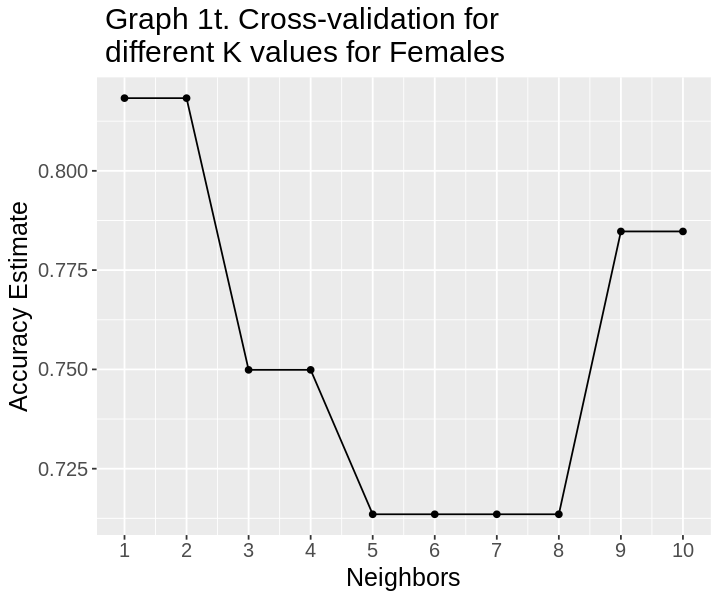

In [16]:
set.seed(127)
library(kknn)

options(repr.plot.height = 5, repr.plot.width = 6)

train_female <- hungarian_data_train |>
filter (sex == "Female")


recipe_female <- recipe(num ~ age + trestbps + chol+ thalac + oldpeak , data = train_female)|>
step_scale(all_predictors())|>
step_center(all_predictors()) |>
step_upsample(num, over_ratio = 1, skip = TRUE) |>
step_impute_mean(all_predictors()) 


vfold_female <- vfold_cv(train_female, v = 5, strata = num)

model <- nearest_neighbor (weight_func ="rectangular", neighbors = tune())|>
                                set_engine ("kknn")|>
                                set_mode ("classification")

values <- tibble(neighbors = seq(from= 1, to = 10 , by = 1))

knn_female <- workflow() |>
     add_recipe(recipe_female) |>
     add_model(model) |>
     tune_grid(resamples = vfold_female, grid = values) |>
     collect_metrics()

accuracy_female<- knn_female |> 
      filter(.metric == "accuracy")


cross_val_females <- ggplot(accuracy_female, aes(x = neighbors, y = mean))+
                     geom_point() +
                     geom_line() +
                     labs(x = "Neighbors", y = "Accuracy Estimate") + 
                     ggtitle (" Graph 1t. Cross-validation for \n different K values for Females")+
                     scale_x_continuous(breaks = 1:10) +
                     theme(text = element_text(size = 15))
            

accuracy_female_max <- accuracy_female |>
                       arrange(desc(mean)) |>
                       slice(1)

# the K value for max accuracy of the female classifier
accuracy_female_max
# Graph 1t.
cross_val_females

# Summary
 As we can see the maximum accuracy obtained after cross folds validation is from a classifier that uses K = 1 for females

## Training the KNN model to work with male training data, and evaluating performance for different K values

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,binary,0.7621395,5,0.04439942,Preprocessor1_Model09


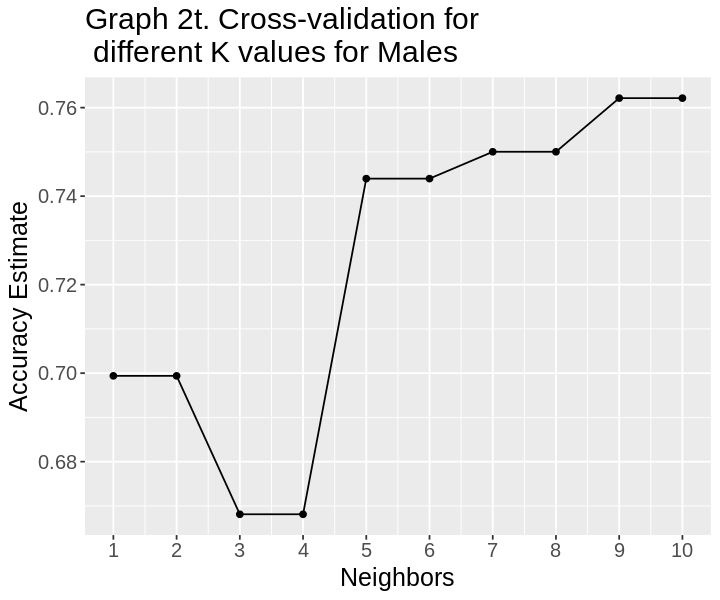

In [17]:

train_male <- hungarian_data_train |>
filter ( sex == "Male")


recipe_male <- recipe(num ~ age + trestbps + chol+ thalac + oldpeak , data = train_male)|>
step_scale(all_predictors())|>
step_center(all_predictors()) |>
step_upsample(num, over_ratio = 1, skip = TRUE) |>
step_impute_mean(all_predictors())

vfold_male <- vfold_cv(train_male, v = 5, strata = num)
model <- nearest_neighbor (weight_func ="rectangular", neighbors = tune())|>
                                set_engine ("kknn")|>
                                set_mode ("classification")

knn_male <- workflow() |>
     add_recipe(recipe_male) |>
     add_model(model) |>
     tune_grid(resamples = vfold_male, grid = values) |>
     collect_metrics()

accuracy_male<- knn_male |> 
      filter(.metric == "accuracy")


cross_val_males <- ggplot(accuracy_male, aes(x = neighbors, y = mean))+
                   geom_point() +
                   geom_line() +
                   labs(x = "Neighbors", y = "Accuracy Estimate") + 
                   ggtitle ("Graph 2t. Cross-validation for \n different K values for Males")+
                   scale_x_continuous(breaks = 1:10) +
                   theme(text = element_text(size = 15))

accuracy_male_max <- accuracy_male |>
                    arrange(desc(mean)) |>
                    slice(1)


#the K value for max accuracy of female classifier
accuracy_male_max
#graph 2t
cross_val_males

# Summary
As we can see maximum accuracy is obtained with K = 9 neighbors when working with the male data.

## Splitting the testing data set into separate male and female data set 
### Table 7. Female Testing Data Set
### Table 8. Male Testing Data Set

In [18]:
## Before working to predict the test data, we first split the test data into male and female test 
female_test <- hungarian_data_test |>
               filter(sex == "Female")
male_test <- hungarian_data_test |>
             filter(sex == "Male")

# Table 7
female_test
#Table 8.
male_test

age,sex,trestbps,chol,thalac,oldpeak,num
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
35,Female,140,167,150,0,Negative
37,Female,130,211,142,0,Negative
41,Female,130,245,150,0,Negative
⋮,⋮,⋮,⋮,⋮,⋮,⋮
47,Female,135,248,170,0.0,Positive
48,Female,138,214,108,1.5,Positive
56,Female,120,279,150,1.0,Positive


age,sex,trestbps,chol,thalac,oldpeak,num
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
36,Male,150,160,172,0,Negative
37,Male,130,194,150,0,Negative
39,Male,130,NA,120,0,Negative
⋮,⋮,⋮,⋮,⋮,⋮,⋮
66,Male,140,NA,94,1.0,Positive
44,Male,135,491,135,0.0,Positive
50,Male,140,341,125,2.5,Positive


## Using Female Classifier on Testing Data and Performance Evaluation
### Table 1r. Accuracy for Female Classifier
### Table 2r. Precision for Female Classifier
### Table 3r. Recall for Female Classifier
### Table 4r. Confusion Matrix for Female Classifier

In [19]:
## first create the classifier with the best number of K values for females
knn_female_max_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) |>
                       set_engine("kknn") |>
                       set_mode("classification")

# now we will use the original recipe for female data and make our workflow for this spec
knn_final_female_fit <- workflow() |>
                             add_recipe(recipe_female) |>
                             add_model(knn_female_max_spec) |>
                             fit(train_female)


# now we use this workflow to predict the test set, but first we split the test set into male and female
female_prediction <- predict(knn_final_female_fit, female_test) |>
                     bind_cols(female_test)



female_prediction_accuracy <- female_prediction |>
                              metrics(truth = num, estimate = .pred_class) |>
                              filter(.metric == "accuracy")
#Table 1r
female_prediction_accuracy 

# this tells us that the first level is a negative diagnosis and positive is the second level 
female_prediction |> pull(num) |> levels()

# female_prediction_precision
#Table 2r
female_prediction |> precision(truth = num, estimate = .pred_class, event_level = "second")
#Table 3r
female_prediction |> recall(truth = num, estimate = .pred_class, event_level = "second")
#Table 4r
female_prediction |> conf_mat(truth = num, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8095238


[1] "Negative" "Positive"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.2


          Truth
Prediction Negative Positive
  Negative       16        4
  Positive        0        1

## Using Male Classifier on Testing Data and Performance Evaluation
### Table 5r. Accuracy for Male Classifier
### Table 6r. Precision for Male Classifier
### Table 7r. Recall for Male Classifier
### Table 8r. Confusion Matrix for Male Classifier

In [20]:
## first create the classifier with the best number of K values for males
knn_male_max_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
                       set_engine("kknn") |>
                       set_mode("classification")

# now we will use the original recipe for males data and make our workflow for this spec
knn_final_male_fit <- workflow() |>
                             add_recipe(recipe_male) |>
                             add_model(knn_male_max_spec) |>
                             fit(train_male)



male_prediction <- predict(knn_final_male_fit, male_test) |>
                     bind_cols(male_test)



male_prediction_accuracy <- male_prediction |>
                              metrics(truth = num, estimate = .pred_class) |>
                              filter(.metric == "accuracy")
#Table 5r
male_prediction_accuracy 

# this tells us that the first level is a negative diagnosis and positive is the second level 
male_prediction |> pull(num) |> levels()

# Table 6r
male_prediction |> precision(truth = num, estimate = .pred_class, event_level = "second")
# Table 7r
male_prediction |> recall(truth = num, estimate = .pred_class, event_level = "second")
# Table 8r
male_prediction |> conf_mat(truth = num, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6981132


[1] "Negative" "Positive"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.6153846


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.7272727


          Truth
Prediction Negative Positive
  Negative       21        6
  Positive       10       16

# Results & Discussion:

#### Results
We found that the best K-value is 1 for females and 9 for males. Based on these K-values, our models returned an accuracy rating of 80.9% for females and 69.8% for males. However, it is important to note that the precision and recall rates reveal more promising results from the male model. The recall rating for female diagnoses is 20%, meaning that 80% of the actual positive diagnoses were false negatives under our model. Given this model is meant to predict CAD, an 80% false negative rate is unideal. In addition to this, while precision had a 100% success rate, it should be noted that of the 17 diagnoses, the model only predicted 1 positive diagnosis. These results, along with a low best K-value for females, are due to the significant lack of data for females within this sample group, and the data overall. Because there are only 60 female observations in the entire dataset, we oversampled the data to combat the issue. However, even with this solution, the lack of data on females - in particular, positively diagnosed females - is too substantial for the classifier to produce normal, expected results. For males, the recall rating was 72.7%, meaning 27.2% of actual positive diagnoses were false negatives under our model. This is significantly higher than the female recall rating. While male precision was only 61.5% and the male model had an overall lower accuracy rating, the recall ratings show that it produced fewer false negatives and therefore performed better than the female model, which are the important values to look at when considering medical diagnoses.

#### Discussion
From the classifier created in this project, we determined that there is a substantial difference when creating K-nn predictive models for females and males. These results were expected as previous diagnosis models for CAD have shown the same trend, however these models use a feature ranking voting (FVR) algorithm as opposed to the K-nn model presented in this report (Hogo, 2020). The FVR model was tested using different datasets and overall, the gender-based models had significantly higher accuracy than the non-gender-based models (Hogo, 2020). From this information, we can state that gender is an essential variable when diagnosing patients with CAD, and most likely other cardiovascular diseases. This trend has also been observed in other diseases; age-gender diagnosis models for Parkinson’s Disease have been shown to be more accurate than generalized models (Khera et al., 2022). Thus, we can expect the same trend to be observed in models predicting different diseases, not necessarily only those affecting the cardiovascular system or the nervous system.

From this, we can potentially create different classifiers for other diseases that affect the other nine major organ systems in the body and determine if there is a higher accuracy for gender-based models in all cases. Moreover, we are most likely working with non-race-inclusive data because our dataset was obtained from a Hungarian medical database. To counteract this issue we would have to test our model against a database with a better representation of all races. If the model proves not to be efficient for other data sets, we could train it again to increase the accuracy despite the race or create a model that considers race as an additional variable.